In [1]:
import copy
import datetime as dt
from pathlib import Path
import warnings
import sys

import holidays
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


pd.options.mode.chained_assignment = None  # default='warn'
matplotlib.rcParams.update({'font.size': 15})
warnings.simplefilter("ignore")
sys.path.insert(0, Path.cwd().parent.as_posix())

from src.utils import expand_time, gdp_countries, plot_data

In [2]:
BASE_PATH = Path.cwd().parent
DATA_PATH = BASE_PATH / "data"

train = pd.read_csv(DATA_PATH / "train.csv")

In [3]:
train.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


## Data Distribution

Leveraging sales data from 2017 to 2021, our objective is to develop a predictive model to forecast 'num_sold' for the forthcoming year, 2022. This predictive modeling hinges on a thorough grasp of four key components: date, country, store, and the specific product category. Consequently, our initial step involves a methodical analysis of the correlation between 'num_sold' and each of these four variables.

In [4]:
# explore unique column entries
unique_values = {}
columns = ["country", "store", "product"]

for column in columns:
    unique_values[column] = train[column].unique()
    print(f"Unique entires in {column}:\n{unique_values[column]}\n")

Unique entires in country:
['Argentina' 'Canada' 'Estonia' 'Japan' 'Spain']

Unique entires in store:
['Kaggle Learn' 'Kaggle Store' 'Kagglazon']

Unique entires in product:
['Using LLMs to Improve Your Coding' 'Using LLMs to Train More LLMs'
 'Using LLMs to Win Friends and Influence People'
 'Using LLMs to Win More Kaggle Competitions' 'Using LLMs to Write Better']



In [5]:
# Creating variables for analysis
analysis = train.drop(columns='id')
print(f"before: {analysis.columns}\n")

# create more features based on the date column
analysis, date_columns = expand_time(analysis)
print(f"after: {analysis.columns}")

before: Index(['date', 'country', 'store', 'product', 'num_sold'], dtype='object')

after: Index(['date', 'country', 'store', 'product', 'num_sold', 'day', 'week',
       'month', 'year', 'day_of_year', 'time_no'],
      dtype='object')


### Plots - Store

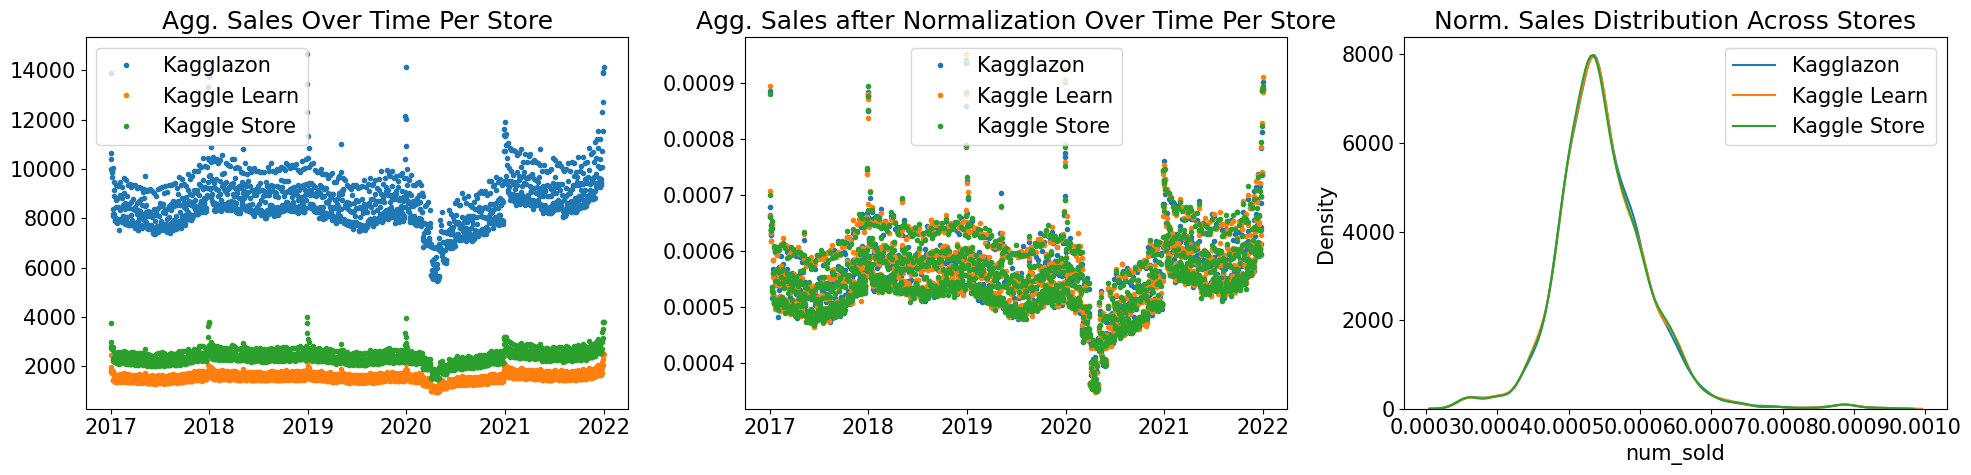

In [6]:
# ----Store----

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
grouped_data_store = analysis.groupby(['date', 'store'])['num_sold'].sum().reset_index()

plot_data(axs, grouped_data_store, "store")


axs[0].set_title('Agg. Sales Over Time Per Store')
axs[1].set_title('Agg. Sales after Normalization Over Time Per Store')
axs[2].set_title('Norm. Sales Distribution Across Stores')

plt.tight_layout()
plt.show()

After analyzing the retail outlets, it's evident that they showcase comparable sales distributions, varying only by a scalar factor. This trend becomes noticeable when standardizing the sales of each store by its overall sales and comparing the resulting distributions, as depicted earlier.

### Plots - Country

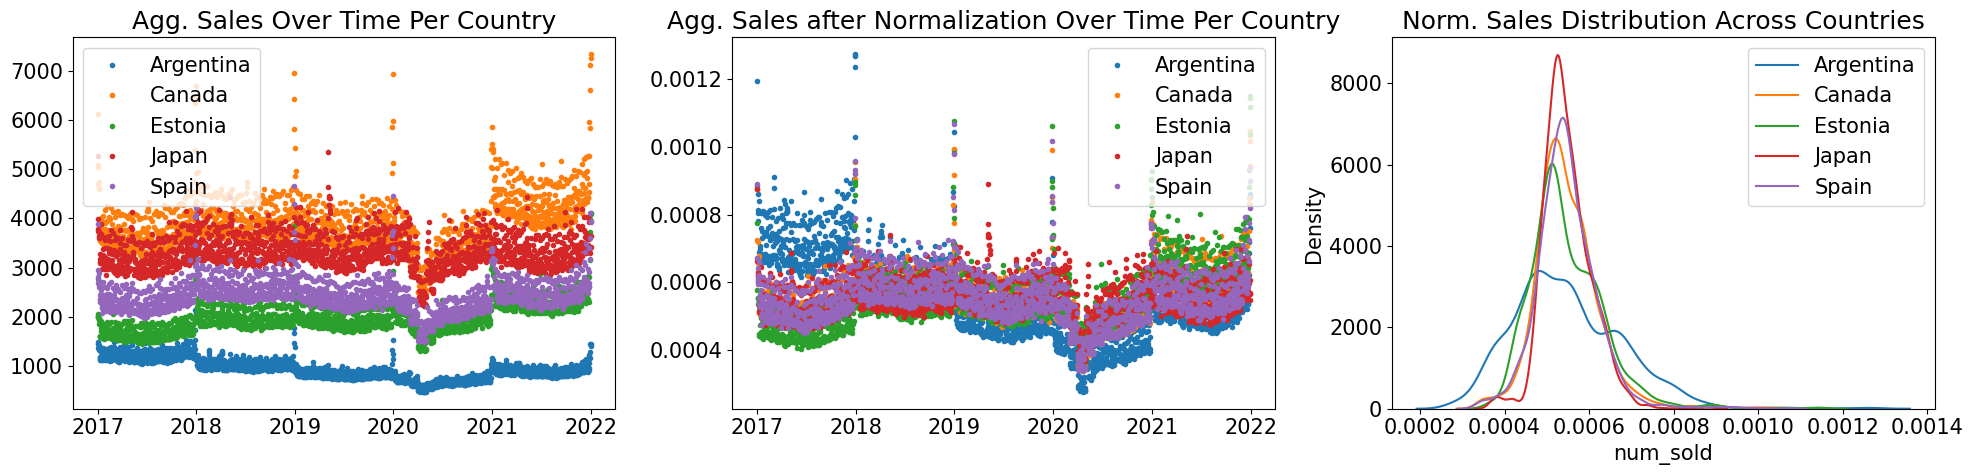

In [7]:
# ----Country----

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
grouped_data_country = analysis.groupby(['date', 'country'])['num_sold'].sum().reset_index()

plot_data(axs, grouped_data_country, "country")

axs[0].set_title('Agg. Sales Over Time Per Country')
axs[1].set_title('Agg. Sales after Normalization Over Time Per Country')
axs[2].set_title('Norm. Sales Distribution Across Countries')

plt.tight_layout()
plt.show()

Our analysis has unveiled valuable insights:

There's a noticeable disparity in 'num_sold' across various years, indicating significant changes in sales volume from year to year.
Within each year, 'num_sold' follows a consistent pattern across different countries, although the extent of change between years varies by country.
Based on these findings, we propose one approach for our prediction model:

Trend-Based Projection:
We can assume that sales in 2022 will follow a similar trend to that of 2021. By adjusting the 'num_sold' values for each year to align with the 2021 levels, we aim to utilize this adjusted data for more accurate sales predictions in 2022. Instead of manually adjusting the levels, we can investigate if other available variables can explain the differences observed among different countries. Using these variables may improve the accuracy of our predictions.

This approach offers us a valuable strategy to refine our predictive model and optimize sales forecasts for the upcoming year, 2022.

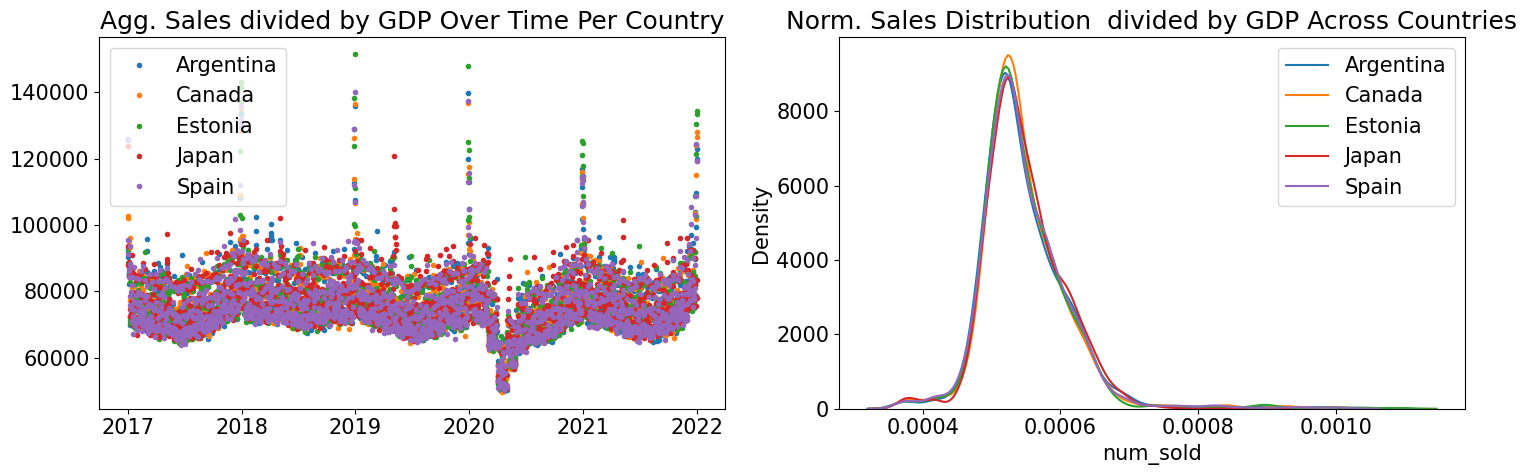

In [8]:
# ----refinement of changes between years----

# collect GDP data for countries
gdp = gdp_countries(train.country.unique())

rel_gdp_df = pd.DataFrame(
    gdp, index=analysis.country.unique(), columns=range(2017, 2023))

grouped_data_country['rel_gdp'] = grouped_data_country.apply(
    lambda s: rel_gdp_df.loc[s.country, s.date.year], axis=1)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_data(axs, grouped_data_country, column="country", adj_column="rel_gdp")

axs[0].set_title('Agg. Sales divided by GDP Over Time Per Country')
axs[1].set_title(
    'Norm. Sales Distribution  divided by GDP Across Countries')

plt.tight_layout()
plt.show()

It's evident that normalizing by GDP aligns the sales distribution for each country to a considerable extent, suggesting a common underlying trend. However, minor differences persist.

### Plots - Product

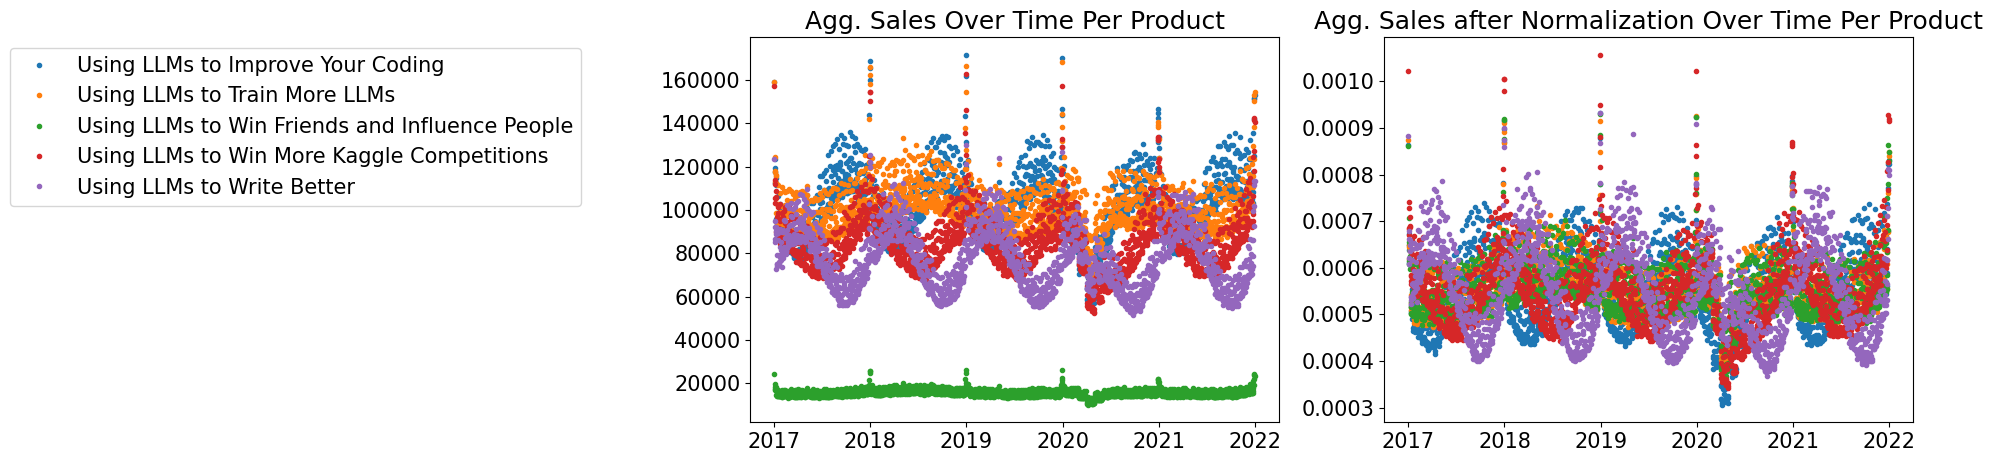

In [15]:
# ----product----

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

grouped_data_gdp = analysis.groupby(
    ['date', 'country','product'])['num_sold'].sum().reset_index()
grouped_data_gdp['rel_gdp'] = grouped_data_gdp .apply(
    lambda s: rel_gdp_df.loc[s.country, s.date.year], axis=1)
grouped_data_gdp['num_sold'] = grouped_data_gdp['num_sold']/grouped_data_gdp['rel_gdp']

grouped_data_product = grouped_data_gdp.groupby(
    ['date','product'])['num_sold'].sum().reset_index()

plot_data(axs, grouped_data_product, "product")


axs[0].set_title('Agg. Sales Over Time Per Product')
axs[1].set_title('Agg. Sales after Normalization Over Time Per Product')

axs[0].get_legend().remove()
axs[1].legend(bbox_to_anchor=(-1.5, 1), loc='upper right')

plt.tight_layout()
plt.show()

In every product, we notice that the sales trend displays both sine and cosine components, suggesting a cyclical pattern. However, the amplitudes of these cyclical components differ across various products. Therefore, we'll analyze each product individually.

Additionally, noticeable sales peaks coincide with holiday seasons.

It's important to note that the year 2020 stands out due to the impact of COVID-19, 
resulting in a deviation from typical sales patterns.

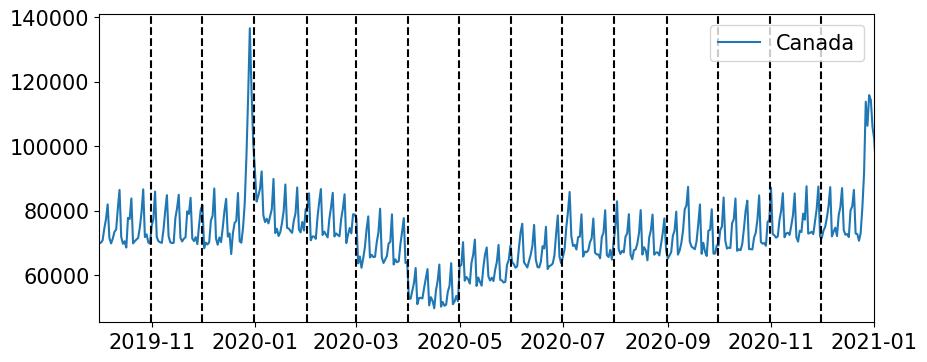

In [16]:
# ----check covid----

df_check = analysis.groupby(['date', 'country'])[['num_sold']].sum().reset_index()

df_check['rel_gdp'] = df_check.apply(
    lambda s: rel_gdp_df.loc[s.country, s.date.year], axis=1)

fig = plt.figure(figsize=(10, 4))

# Iterate over unique countries and plot the sales normalized by GDP
for i, country in enumerate(unique_values['country'][1:2]):
    X = df_check[df_check['country'] == country]
    plt.plot(X['date'], X['num_sold']/X['rel_gdp'], label=country)
    plt.legend()
    plt.xlim([dt.date(2019, 10, 1), dt.date(2021, 1, 1)])

    # Add vertical dashed lines
    for i in range(10, 13):
        datetime1 = dt.datetime(2019, i, 1) - dt.timedelta(days=1)
        datetime2 = dt.datetime(2019, i, 1)
        mid_datetime = datetime1 + (datetime2 - datetime1) / 2
        plt.axvline(mid_datetime, color='k', linestyle='--')

    # Add vertical dashed lines
    for i in range(1, 13):
        datetime1 = dt.datetime(2020, i, 1) - dt.timedelta(days=1)
        datetime2 = dt.datetime(2020, i, 1)
        mid_datetime = datetime1 + (datetime2 - datetime1) / 2
        plt.axvline(mid_datetime, color='k', linestyle='--')


We can see that covid acts monthly.

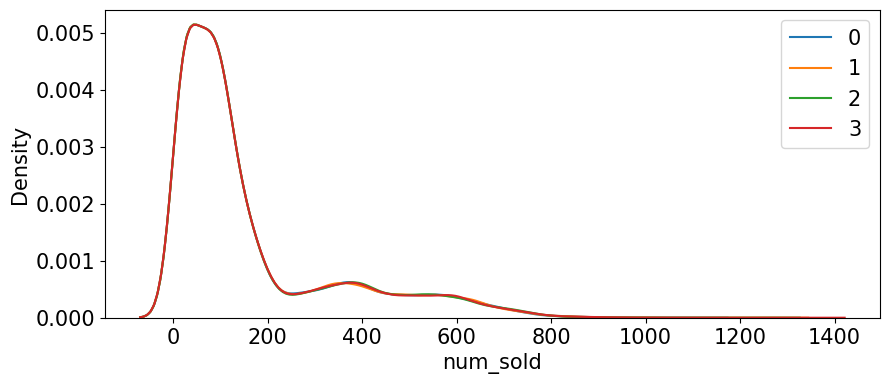

In [9]:
fig = plt.figure(figsize=(10, 4))

for w in [0,1,2,3]:
    w_data = analysis[analysis['week'] == w]['num_sold']
    sns.kdeplot(w_data, label=w)

plt.legend()
plt.show()

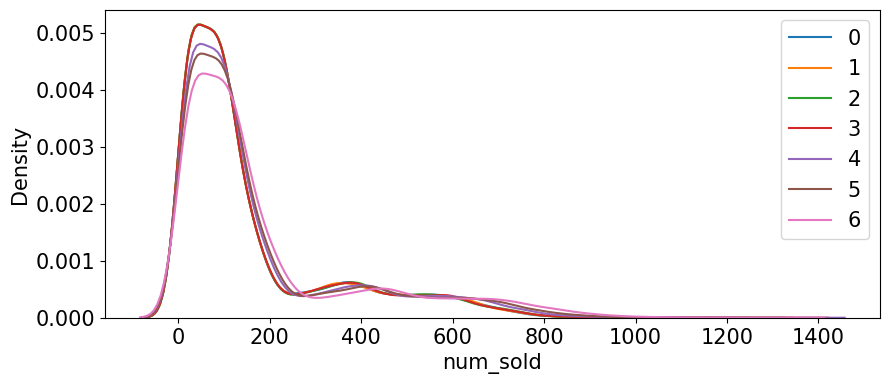

In [10]:
fig = plt.figure(figsize=(10, 4))

for w in [0, 1, 2, 3, 4, 5, 6]:
    w_data = analysis[analysis['week'] == w]['num_sold']
    sns.kdeplot(w_data, label=w)

plt.legend()
plt.show()

We see that the distribution of Monday-Thursday are the same, while Firday-Sunday are different.

